<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 2
<br>
<b>Deadline:</b> May 23, 2020 (Saturday) 23:00
</div>

# Exercise 11.2. Generative adversarial networks (GANs). WGAN-GP: Wasserstein GAN with gradient penalty

The goal of this exercise is to get familiar with WGAN-GP: one of the most popular versions of GANs, which is relatively easy to train.

The algorithm was introduced in the paper [Improved Training of Wasserstein GANs](https://arxiv.org/pdf/1704.00028.pdf).

In [0]:
skip_training = False  # Set this flag to True before validation and submission

In [0]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
import torchvision.utils as utils

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [0]:
device = torch.device('cuda:0')
# device = torch.device('cpu')

In [0]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

We will use MNIST data in this exercise.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Min-max scaling to [-1, 1]
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


# Wasserstein GAN (WGAN)

The WGAN value function is constructed as
$$
  \min_G \max_{D \in \mathcal{D}} E_{x∼P_r}[D(x)] − E_{\tilde x∼P_g}[D(\tilde x)]
$$
where
* the dicriminator $D$ (called critic in WGAN) is constrained to be from the set $\mathcal{D}$ of 1-Lipschitz functions
* $P_r$ is the data distribution
* $P_g$ is the model distribution. Samples from the model distribution are produced as follows:
\begin{align}
z &\sim N(0, I)
\\
\tilde x &= G(z)
\end{align}

## Generator

Implement the generator in the cell below. We recommend you to use the same architecture of the generator as in Exercise 11.1.

In [0]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        """WGAN generator.
        
        Args:
          nz:  Number of elements in the latent code.
          ngf: Base size (number of channels) of the generator layers.
          nc:  Number of channels in the generated images.
        """
        # YOUR CODE HERE
        super(Generator, self).__init__()
        self.ConvTrans1 = nn.ConvTranspose2d(in_channels=nz, out_channels=4*ngf, kernel_size=4, stride=2, padding=0,  bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(num_features=4*ngf)
        self.ConvTrans2 = nn.ConvTranspose2d(4*ngf, 2*ngf, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(2*ngf)
        self.ConvTrans3 = nn.ConvTranspose2d(2*ngf, ngf, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf)
        self.ConvTrans4 = nn.ConvTranspose2d(ngf, nc, 4, 2, 3, bias=False)

    def forward(self, z, verbose=False):
        """Generate images by transforming the given noise tensor.
        
        Args:
          z of shape (batch_size, nz, 1, 1): Tensor of noise samples. We use the last two singleton dimensions
              so that we can feed z to the generator without reshaping.
          verbose (bool): Whether to print intermediate shapes (True) or not (False).
        
        Returns:
          out of shape (batch_size, nc, 28, 28): Generated images.
        """
        # YOUR CODE HERE
        if verbose: print("before :", z.size())
        z = F.relu(self.BatchNorm1(self.ConvTrans1(z)))
        if verbose: print(z.size())
        z = F.relu(self.BatchNorm2(self.ConvTrans2(z)))
        if verbose: print(z.size())
        z = F.relu(self.BatchNorm3(self.ConvTrans3(z)))
        if verbose: print(z.size())
        z = torch.tanh(self.ConvTrans4(z))
        if verbose: print("after :", z.size())

        return z

In [9]:
def test_Generator_shapes():
    batch_size = 32
    nz = 10
    netG = Generator(nz, ngf=64, nc=1)

    noise = torch.randn(batch_size, nz, 1, 1)
    out = netG(noise, verbose=True)

    assert out.shape == torch.Size([batch_size, 1, 28, 28]), f"Bad out.shape: {out.shape}"
    print('Success')

test_Generator_shapes()

before : torch.Size([32, 10, 1, 1])
torch.Size([32, 256, 4, 4])
torch.Size([32, 128, 8, 8])
torch.Size([32, 64, 16, 16])
after : torch.Size([32, 1, 28, 28])
Success


### Loss for training the generator

The generator is trained to minimize the relevant part of the value function using a fixed critic $D$:
$$
  \min_G − E_{\tilde{x} \sim P_g}[D( \tilde x)]
$$

In [0]:
def generator_loss(D, fake_images):
    """Loss computed to train the WGAN generator.

    Args:
      D: The critic whose forward function takes inputs of shape (batch_size, nc, 28, 28)
         and produces outputs of shape (batch_size, 1).
      fake_images of shape (batch_size, nc, 28, 28): Fake images produces by the generator.

    Returns:
      loss: The relevant part of the WGAN value function.

    Notes:
    - Make sure that you process on the device given by `fake_images.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    # YOUR CODE HERE
    return -torch.mean(D(fake_images))

In [0]:
# This cell tests generator_loss()

## Critic

In WGAN, the discriminator is called a critic because **it is not trained to classify**.

Implement the WGAN critic in the cell below. You can use almost the same architecture as the architecture of the discriminator in Exercise 11.1. The difference is that there is no need to use `sigmoid` nonlinearity in the output layer because the output of the critic does not have to be between 0 and 1.

In [0]:
class Critic(nn.Module):
    def __init__(self, nc=1, ndf=64):
        """
        Args:
          nc:  Number of channels in the images.
          ndf: Base size (number of channels) of the critic layers.
        """
        # YOUR CODE HERE
        super(Critic, self).__init__()
        self.Conv1 = nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False)
        self.LRelu1 = nn.LeakyReLU(negative_slope=0.2)
        self.Conv2 = nn.Conv2d(ndf, 2*ndf, 4, 2, padding=1, bias=False)
        self.LRelu2 = nn.LeakyReLU(0.2)
        self.Conv3 = nn.Conv2d(2*ndf, 4*ndf, 4, 2, padding=1, bias=False)
        self.LRelu3 = nn.LeakyReLU(0.2)
        self.Conv4 = nn.Conv2d(4*ndf, nc, 4, 2, padding=1, bias=False)

    def forward(self, x, verbose=False):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Images to be evaluated.
        
        Returns:
          out of shape (batch_size,): Critic outputs for images x.
        """
        # YOUR CODE HERE
        if verbose: print("before :", x.size())
        x = self.LRelu1(self.Conv1(x))
        if verbose: print(x.size())
        x = self.LRelu2(self.Conv2(x))
        if verbose: print(x.size())
        x = self.LRelu3(self.Conv3(x))
        if verbose: print(x.size())
        x = self.Conv4(x).squeeze()
        if verbose: print("after :", x.size())
        
        return x

In [13]:
def test_Critic_shapes():
    nz = 10  # size of the latent z vector
    netD = Critic(nc=1, ndf=64)

    batch_size = 32
    images = torch.ones(batch_size, 1, 28, 28)
    out = netD(images, verbose=True)
    assert out.shape == torch.Size([batch_size]), f"Bad out.shape: {out.shape}"
    print('Success')

test_Critic_shapes()

before : torch.Size([32, 1, 28, 28])
torch.Size([32, 64, 14, 14])
torch.Size([32, 128, 7, 7])
torch.Size([32, 256, 3, 3])
after : torch.Size([32])
Success


### Loss for training the WGAN critic

Recall the value function of WGAN:
$$
  \min_G \max_{D \in \mathcal{D}} E_{x∼P_r}[D(x)] − E_{\tilde x∼P_g}[D(\tilde x)]
$$
To tune the critic, we need to minimize the following function:
$$
  \min_{D \in \mathcal{D}} - E_{x∼P_r}[D(x)] + E_{\tilde x∼P_g}[D(\tilde x)]
$$
You need to implement this loss function **assuming no constraints on D** in the function below.

In [0]:
def critic_loss(critic, real_images, fake_images):
    """
    Args:
      critic: The critic.
      real_images of shape (batch_size, nc, 28, 28): Real images.
      fake_images of shape (batch_size, nc, 28, 28): Fake images.

    Returns:
      loss (scalar tensor): Loss for training the WGAN critic.
    """
    # YOUR CODE HERE
    return -torch.mean(critic(real_images)) + torch.mean(critic(fake_images))

In [0]:
# This cell tests critic_loss()

Without constraints on $D$, the WGAN value function can be made infinitely large. WGAN constrains the derivative of $D$ using a **gradient penalty**. The penalty is computed at random points between real images and generated ones using the following procedure:
* Given a real image $x$ and a fake image $\tilde x$, draw a random number $\epsilon \sim U[0,1]$
* $\hat{x} \leftarrow \epsilon x + (1−\epsilon) \tilde x$
* Compute the gradient penalty $(‖\nabla_{\hat{x}} D(\hat{x})‖_2−1)^2$
where $\nabla_{\hat{x}} D(\hat{x})$ is the gradient of $D$ computed at $\hat{x}$.

Your task is to implement the gradient penalty in the cell below. Note that we need to compute the gradient $\nabla D$ so that we can differentiate through the gradient when computing the derivatives wrt the parameters of the critic. This can be achieved by using function [torch.autograd.grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad) which can create a computational graph with the gradient computations.

In [0]:
def gradient_penalty(critic, real, fake_detached):
    """
    Args:
      critic: The critic.
      real of shape (batch_size, nc, 28, 28): Real images.
      fake_detached of shape (batch_size, nc, 28, 28): Fake images (detached from the computational graph).

    Returns:
      grad_penalty (scalar tensor): Gradient penalty.
      x of shape (batch_size, nc, 28, 28): Points x-hat in which the gradient penalty is computed.
    """
    # YOUR CODE HERE
    batch_size, nc = real.size()[:2]
    eps = torch.rand((batch_size, nc, 1, 1), device=fake_detached.device)
    interpolated = torch.autograd.Variable(eps*real + (1-eps)*fake_detached, requires_grad=True)
    
    scores = critic(interpolated)
    
    gradients = torch.autograd.grad(outputs=scores,
                                    inputs=interpolated,
                                    grad_outputs=torch.ones(scores.size(), device=fake_detached.device),
                                    retain_graph=True,
                                    create_graph=True)[0]
                                    
    grad_penalty = torch.pow(torch.norm(gradients, p=2) - 1, 2)
    x = interpolated
    
    return grad_penalty, x

In [17]:
tests.test_gradient_penalty(gradient_penalty)

loss: tensor(729., grad_fn=<PowBackward0>)
expected: tensor(729.)
Success


# Training WGAN-GP

We will now train WGAN-GP. To assess the quality of the generated samples, we will use a simple scorer loaded in the cell below.

In [18]:
from scorer import Scorer
scorer = Scorer()
scorer.to(device)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


Scorer(
  (model): MLP(
    (model): Sequential(
      (fc1): Linear(in_features=784, out_features=256, bias=True)
      (relu1): ReLU()
      (drop1): Dropout(p=0.2, inplace=False)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (relu2): ReLU()
      (drop2): Dropout(p=0.2, inplace=False)
      (out): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)

In [0]:
# Create the network
nz = 10
netG = Generator(nz=nz, ngf=128, nc=1).to(device)
netD = Critic(nc=1, ndf=128).to(device)

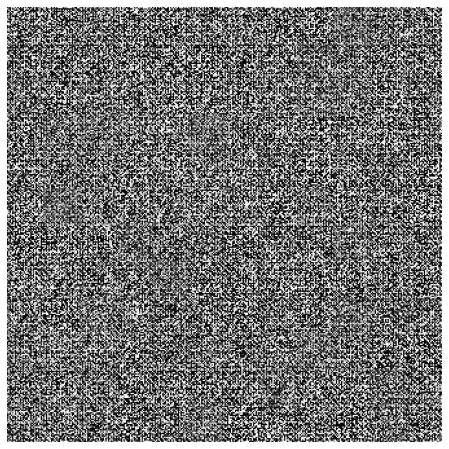

In [20]:
with torch.no_grad():
    # Plot generated images
    z = torch.randn(144, nz, 1, 1, device=device)
    samples = netG(z)
    tools.plot_generated_samples(samples)
    
    # Compute score
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = netG(z)
    samples = (samples + 1) / 2  # Re-normalize to [0, 1]
    score = scorer(samples)

### Training loop

Implement the training loop in the cell below. The recommended hyperparameters:
* Optimizer of the critic:    Adam with learning rate 0.0001
* Optimizer of the generator: Adam with learning rate 0.0001
* Weight $\lambda=10$ of the gradient penalty term in the discriminator loss:
$$
  \min_{D} - E_{x∼P_r}[D(x)] + E_{\tilde x∼P_g}[D(\tilde x)]
  + \lambda (‖\nabla_{\hat{x}} D(\hat{x})‖_2−1)^2
$$

Hints:
- We will use the scorer defined above to assess the quality of the generated samples. The desired level of 0.66 should be reached within 15-20 epochs.
- You can use the following code to track the training progress. The code plots some generated images and computes the score that we use to evaluate the trained model. Note that the images fed to the scorer need to be normalized to be in the range [0, 1].
```
with torch.no_grad():
    # Plot generated images
    z = torch.randn(144, nz, 1, 1, device=device)
    samples = netG(z)
    tools.plot_generated_samples(samples)
    
    # Compute score
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = netG(z)
    samples = (samples + 1) / 2  # Re-normalize to [0, 1]
    score = scorer(samples)
```
- The quality of the images is slightly worse than with the DCGAN.

Epoch 0
[0][0][0/1875] Loss_D: 7.0389 Loss_G: 0.0449
[0][100][100/1875] Loss_D: -3.9022 Loss_G: 1.4684
[0][200][200/1875] Loss_D: -3.7494 Loss_G: 1.9622
[0][300][300/1875] Loss_D: -3.4811 Loss_G: 1.8266
[0][400][400/1875] Loss_D: -3.4267 Loss_G: 1.4249
[0][500][500/1875] Loss_D: -3.2350 Loss_G: 1.8667
[0][600][600/1875] Loss_D: -3.2936 Loss_G: 1.5732
[0][700][700/1875] Loss_D: -3.3084 Loss_G: 1.1945
[0][800][800/1875] Loss_D: -3.0554 Loss_G: 1.1284
[0][900][900/1875] Loss_D: -3.0267 Loss_G: 1.5469
[0][1000][1000/1875] Loss_D: -3.0341 Loss_G: 1.5008
[0][1100][1100/1875] Loss_D: -3.0512 Loss_G: 1.6377
[0][1200][1200/1875] Loss_D: -3.0196 Loss_G: 1.5773
[0][1300][1300/1875] Loss_D: -2.6091 Loss_G: 1.0035
[0][1400][1400/1875] Loss_D: -2.3014 Loss_G: 1.0078
[0][1500][1500/1875] Loss_D: -2.4050 Loss_G: 1.1698
[0][1600][1600/1875] Loss_D: -2.3518 Loss_G: 1.1284
[0][1700][1700/1875] Loss_D: -2.3380 Loss_G: 0.7327
[0][1800][1800/1875] Loss_D: -2.3072 Loss_G: 1.1066


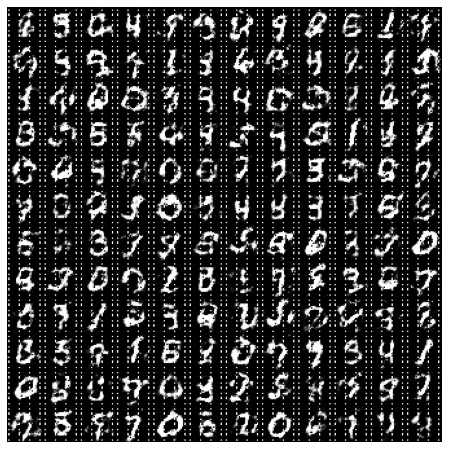

Epoch 1
[1][1875][0/1875] Loss_D: -2.3601 Loss_G: 1.0705
[1][1975][100/1875] Loss_D: -2.3144 Loss_G: 1.0659
[1][2075][200/1875] Loss_D: -2.3621 Loss_G: 1.1459
[1][2175][300/1875] Loss_D: -2.3534 Loss_G: 1.0823
[1][2275][400/1875] Loss_D: -2.3113 Loss_G: 0.8144
[1][2375][500/1875] Loss_D: -2.3763 Loss_G: 1.2172
[1][2475][600/1875] Loss_D: -2.3310 Loss_G: 0.8316
[1][2575][700/1875] Loss_D: -2.2953 Loss_G: 1.1596
[1][2675][800/1875] Loss_D: -2.2830 Loss_G: 1.0716
[1][2775][900/1875] Loss_D: -2.3123 Loss_G: 0.9848
[1][2875][1000/1875] Loss_D: -2.3185 Loss_G: 1.0718
[1][2975][1100/1875] Loss_D: -2.3652 Loss_G: 1.1024
[1][3075][1200/1875] Loss_D: -2.2795 Loss_G: 0.7273
[1][3175][1300/1875] Loss_D: -2.0721 Loss_G: 0.8084
[1][3275][1400/1875] Loss_D: -2.0404 Loss_G: 0.8533
[1][3375][1500/1875] Loss_D: -2.0579 Loss_G: 1.1487
[1][3475][1600/1875] Loss_D: -2.0276 Loss_G: 0.9940
[1][3575][1700/1875] Loss_D: -2.0222 Loss_G: 0.7807
[1][3675][1800/1875] Loss_D: -2.0708 Loss_G: 0.9227


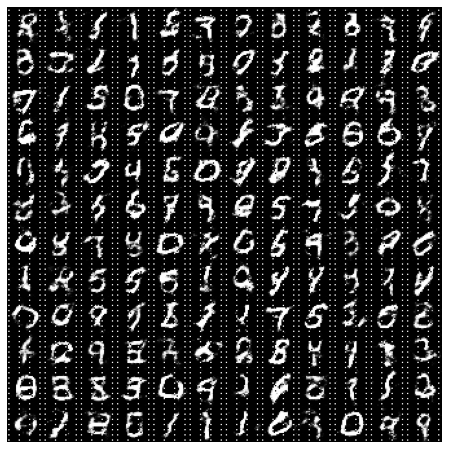

Epoch 2
[2][3750][0/1875] Loss_D: -1.9784 Loss_G: 0.9541
[2][3850][100/1875] Loss_D: -1.9311 Loss_G: 1.1408
[2][3950][200/1875] Loss_D: -1.9668 Loss_G: 0.9909
[2][4050][300/1875] Loss_D: -1.8910 Loss_G: 0.8846
[2][4150][400/1875] Loss_D: -1.9177 Loss_G: 0.9262
[2][4250][500/1875] Loss_D: -1.9115 Loss_G: 0.8400
[2][4350][600/1875] Loss_D: -1.8837 Loss_G: 0.9180
[2][4450][700/1875] Loss_D: -1.8792 Loss_G: 0.8621
[2][4550][800/1875] Loss_D: -1.8949 Loss_G: 0.8973
[2][4650][900/1875] Loss_D: -1.8664 Loss_G: 0.9604
[2][4750][1000/1875] Loss_D: -1.9212 Loss_G: 0.8984
[2][4850][1100/1875] Loss_D: -1.9316 Loss_G: 0.9622
[2][4950][1200/1875] Loss_D: -1.9049 Loss_G: 0.7684
[2][5050][1300/1875] Loss_D: -1.9055 Loss_G: 0.9276
[2][5150][1400/1875] Loss_D: -1.9144 Loss_G: 0.8247
[2][5250][1500/1875] Loss_D: -1.8789 Loss_G: 1.0601
[2][5350][1600/1875] Loss_D: -1.8431 Loss_G: 0.8910
[2][5450][1700/1875] Loss_D: -1.9068 Loss_G: 0.8726
[2][5550][1800/1875] Loss_D: -1.9047 Loss_G: 0.8672


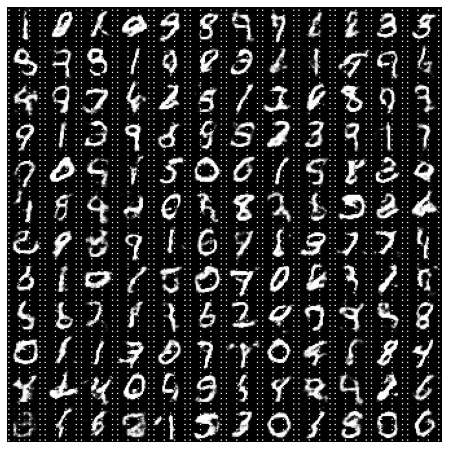

Epoch 3
[3][5625][0/1875] Loss_D: -1.8802 Loss_G: 0.8409
[3][5725][100/1875] Loss_D: -1.8426 Loss_G: 0.9929
[3][5825][200/1875] Loss_D: -1.8896 Loss_G: 0.8674
[3][5925][300/1875] Loss_D: -1.8829 Loss_G: 0.7582
[3][6025][400/1875] Loss_D: -1.8334 Loss_G: 0.8529
[3][6125][500/1875] Loss_D: -1.9195 Loss_G: 0.8783
[3][6225][600/1875] Loss_D: -1.8911 Loss_G: 0.7730
[3][6325][700/1875] Loss_D: -1.9456 Loss_G: 0.8939
[3][6425][800/1875] Loss_D: -1.8662 Loss_G: 0.7810
[3][6525][900/1875] Loss_D: -1.8958 Loss_G: 0.8646
[3][6625][1000/1875] Loss_D: -1.8936 Loss_G: 0.7515
[3][6725][1100/1875] Loss_D: -1.8565 Loss_G: 0.8094
[3][6825][1200/1875] Loss_D: -1.8106 Loss_G: 0.8730
[3][6925][1300/1875] Loss_D: -1.8945 Loss_G: 0.8210
[3][7025][1400/1875] Loss_D: -1.8620 Loss_G: 0.8140
[3][7125][1500/1875] Loss_D: -1.9295 Loss_G: 0.8677
[3][7225][1600/1875] Loss_D: -1.9359 Loss_G: 0.7920
[3][7325][1700/1875] Loss_D: -1.9208 Loss_G: 0.9006
[3][7425][1800/1875] Loss_D: -1.9104 Loss_G: 0.8489


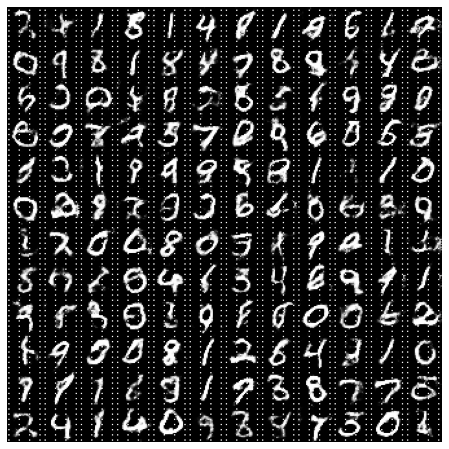

Epoch 4
[4][7500][0/1875] Loss_D: -1.9243 Loss_G: 0.8756
[4][7600][100/1875] Loss_D: -1.8234 Loss_G: 0.8412
[4][7700][200/1875] Loss_D: -1.8690 Loss_G: 0.7793
[4][7800][300/1875] Loss_D: -1.9436 Loss_G: 0.7507
[4][7900][400/1875] Loss_D: -1.9053 Loss_G: 0.8194
[4][8000][500/1875] Loss_D: -1.8665 Loss_G: 0.8316
[4][8100][600/1875] Loss_D: -1.9008 Loss_G: 0.8466
[4][8200][700/1875] Loss_D: -1.9624 Loss_G: 0.8352
[4][8300][800/1875] Loss_D: -1.8773 Loss_G: 0.9521
[4][8400][900/1875] Loss_D: -1.9147 Loss_G: 0.9748
[4][8500][1000/1875] Loss_D: -1.9579 Loss_G: 0.7938
[4][8600][1100/1875] Loss_D: -1.8727 Loss_G: 0.8298
[4][8700][1200/1875] Loss_D: -1.9405 Loss_G: 0.8792
[4][8800][1300/1875] Loss_D: -1.8847 Loss_G: 0.8074
[4][8900][1400/1875] Loss_D: -1.9214 Loss_G: 0.7870
[4][9000][1500/1875] Loss_D: -1.9098 Loss_G: 0.9103
[4][9100][1600/1875] Loss_D: -1.9577 Loss_G: 0.8246
[4][9200][1700/1875] Loss_D: -1.9395 Loss_G: 0.8230
[4][9300][1800/1875] Loss_D: -1.9105 Loss_G: 0.8541


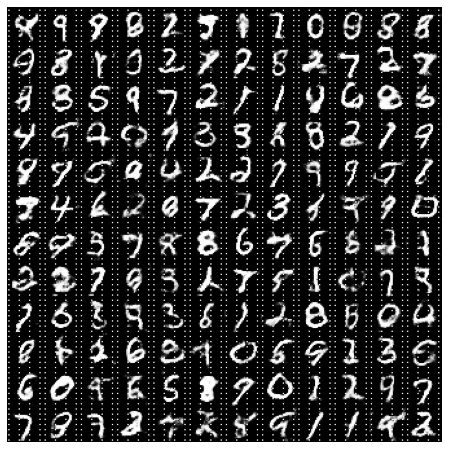

Epoch 5
[5][9375][0/1875] Loss_D: -1.9232 Loss_G: 0.8115
[5][9475][100/1875] Loss_D: -1.9292 Loss_G: 0.8731
[5][9575][200/1875] Loss_D: -1.9508 Loss_G: 0.8165
[5][9675][300/1875] Loss_D: -1.9688 Loss_G: 0.8790
[5][9775][400/1875] Loss_D: -1.9678 Loss_G: 0.9046
[5][9875][500/1875] Loss_D: -1.9704 Loss_G: 0.7563
[5][9975][600/1875] Loss_D: -1.9275 Loss_G: 0.8240
[5][10075][700/1875] Loss_D: -1.9031 Loss_G: 0.9707
[5][10175][800/1875] Loss_D: -1.9176 Loss_G: 0.8186
[5][10275][900/1875] Loss_D: -1.9377 Loss_G: 0.8534
[5][10375][1000/1875] Loss_D: -1.9372 Loss_G: 0.8653
[5][10475][1100/1875] Loss_D: -1.9419 Loss_G: 0.7314
[5][10575][1200/1875] Loss_D: -1.9308 Loss_G: 0.8933
[5][10675][1300/1875] Loss_D: -1.9065 Loss_G: 0.9138
[5][10775][1400/1875] Loss_D: -1.9456 Loss_G: 0.7860
[5][10875][1500/1875] Loss_D: -1.9306 Loss_G: 0.8044
[5][10975][1600/1875] Loss_D: -1.9181 Loss_G: 0.8034
[5][11075][1700/1875] Loss_D: -1.8808 Loss_G: 0.8308
[5][11175][1800/1875] Loss_D: -1.9223 Loss_G: 0.7926


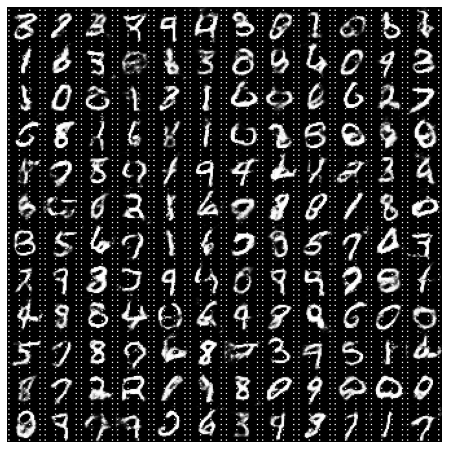

Epoch 6
[6][11250][0/1875] Loss_D: -1.9534 Loss_G: 0.8202
[6][11350][100/1875] Loss_D: -1.8742 Loss_G: 0.8064
[6][11450][200/1875] Loss_D: -0.8723 Loss_G: -0.5374
[6][11550][300/1875] Loss_D: -0.5649 Loss_G: -0.1774
[6][11650][400/1875] Loss_D: -0.6182 Loss_G: -0.4402
[6][11750][500/1875] Loss_D: -0.5013 Loss_G: -0.2705
[6][11850][600/1875] Loss_D: -0.4627 Loss_G: 0.2980
[6][11950][700/1875] Loss_D: -0.4997 Loss_G: 0.4996
[6][12050][800/1875] Loss_D: -0.3863 Loss_G: 0.3185
[6][12150][900/1875] Loss_D: -0.3961 Loss_G: 0.2476
[6][12250][1000/1875] Loss_D: -0.3298 Loss_G: 0.9210
[6][12350][1100/1875] Loss_D: -0.4415 Loss_G: 0.5117
[6][12450][1200/1875] Loss_D: -0.3281 Loss_G: 0.5875
[6][12550][1300/1875] Loss_D: -0.4218 Loss_G: -0.0012
[6][12650][1400/1875] Loss_D: -0.3464 Loss_G: 0.9805
[6][12750][1500/1875] Loss_D: -0.3371 Loss_G: -0.1418
[6][12850][1600/1875] Loss_D: -0.2008 Loss_G: 0.0886
[6][12950][1700/1875] Loss_D: -0.3319 Loss_G: -0.3558
[6][13050][1800/1875] Loss_D: -0.3912 Loss_

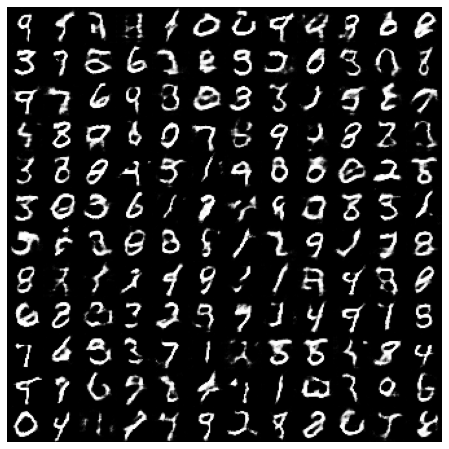

Epoch 7
[7][13125][0/1875] Loss_D: -0.2436 Loss_G: 0.6424
[7][13225][100/1875] Loss_D: -0.3459 Loss_G: -0.0923
[7][13325][200/1875] Loss_D: -0.2894 Loss_G: -1.2181
[7][13425][300/1875] Loss_D: -0.4125 Loss_G: 0.1279
[7][13525][400/1875] Loss_D: -0.4910 Loss_G: 0.0770
[7][13625][500/1875] Loss_D: -0.3347 Loss_G: -0.0331
[7][13725][600/1875] Loss_D: -0.3173 Loss_G: -0.5555
[7][13825][700/1875] Loss_D: -0.3228 Loss_G: 0.3888
[7][13925][800/1875] Loss_D: -0.1633 Loss_G: -0.6597
[7][14025][900/1875] Loss_D: -0.3905 Loss_G: -0.2197
[7][14125][1000/1875] Loss_D: -0.3620 Loss_G: 0.1133
[7][14225][1100/1875] Loss_D: -0.2232 Loss_G: 0.1982
[7][14325][1200/1875] Loss_D: -0.5023 Loss_G: -0.9721
[7][14425][1300/1875] Loss_D: -0.3573 Loss_G: 0.7427
[7][14525][1400/1875] Loss_D: -0.2543 Loss_G: 0.1841
[7][14625][1500/1875] Loss_D: -0.4042 Loss_G: 0.0599
[7][14725][1600/1875] Loss_D: -0.2962 Loss_G: -0.9381
[7][14825][1700/1875] Loss_D: -0.2812 Loss_G: -0.9210
[7][14925][1800/1875] Loss_D: -0.1680 Los

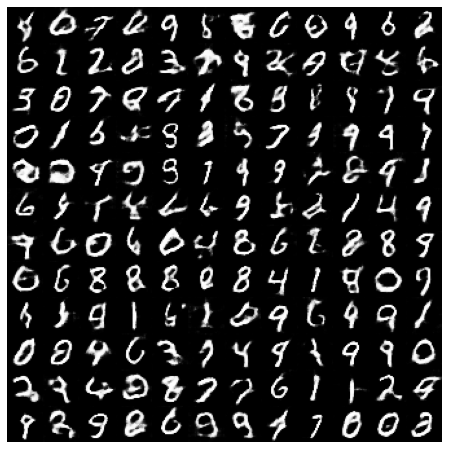

Epoch 8
[8][15000][0/1875] Loss_D: -0.4710 Loss_G: 0.0004
[8][15100][100/1875] Loss_D: -0.3757 Loss_G: -0.7015
[8][15200][200/1875] Loss_D: -0.2795 Loss_G: 0.5988
[8][15300][300/1875] Loss_D: -0.2202 Loss_G: 0.2110
[8][15400][400/1875] Loss_D: -0.2805 Loss_G: -0.5356
[8][15500][500/1875] Loss_D: -0.4456 Loss_G: -0.4076
[8][15600][600/1875] Loss_D: -0.3067 Loss_G: 0.1964
[8][15700][700/1875] Loss_D: -0.2608 Loss_G: -0.6065
[8][15800][800/1875] Loss_D: -0.3538 Loss_G: 0.3022
[8][15900][900/1875] Loss_D: -0.3282 Loss_G: 0.0740
[8][16000][1000/1875] Loss_D: -0.2513 Loss_G: -0.6717
[8][16100][1100/1875] Loss_D: -0.2381 Loss_G: -0.1332
[8][16200][1200/1875] Loss_D: -0.3830 Loss_G: -0.1919
[8][16300][1300/1875] Loss_D: -0.3554 Loss_G: -0.7192
[8][16400][1400/1875] Loss_D: -0.1715 Loss_G: -0.1554
[8][16500][1500/1875] Loss_D: -0.2206 Loss_G: -0.5082
[8][16600][1600/1875] Loss_D: -0.2999 Loss_G: -0.0446
[8][16700][1700/1875] Loss_D: -0.2032 Loss_G: -0.1753
[8][16800][1800/1875] Loss_D: -0.1751 

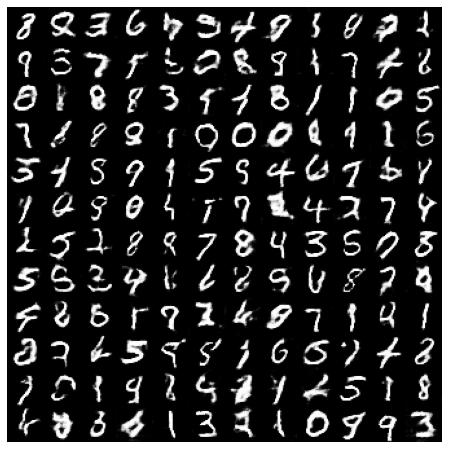

Epoch 9
[9][16875][0/1875] Loss_D: -0.2945 Loss_G: -0.1715
[9][16975][100/1875] Loss_D: -0.2473 Loss_G: -0.6358
[9][17075][200/1875] Loss_D: -0.2954 Loss_G: -0.8288
[9][17175][300/1875] Loss_D: -0.3359 Loss_G: -0.4547
[9][17275][400/1875] Loss_D: -0.1189 Loss_G: -0.1647
[9][17375][500/1875] Loss_D: -0.2925 Loss_G: 0.2962
[9][17475][600/1875] Loss_D: -0.5064 Loss_G: 0.1940
[9][17575][700/1875] Loss_D: -0.3773 Loss_G: -0.2787
[9][17675][800/1875] Loss_D: -0.2725 Loss_G: -1.1464
[9][17775][900/1875] Loss_D: -0.3594 Loss_G: -0.4133
[9][17875][1000/1875] Loss_D: -0.2644 Loss_G: -0.5614
[9][17975][1100/1875] Loss_D: -0.3530 Loss_G: -0.7568
[9][18075][1200/1875] Loss_D: -0.1894 Loss_G: -0.1324
[9][18175][1300/1875] Loss_D: -0.2334 Loss_G: -0.0350
[9][18275][1400/1875] Loss_D: -0.1964 Loss_G: 0.4855
[9][18375][1500/1875] Loss_D: -0.3195 Loss_G: -0.8532
[9][18475][1600/1875] Loss_D: -0.3514 Loss_G: -0.2978
[9][18575][1700/1875] Loss_D: -0.4472 Loss_G: 0.5172
[9][18675][1800/1875] Loss_D: -0.394

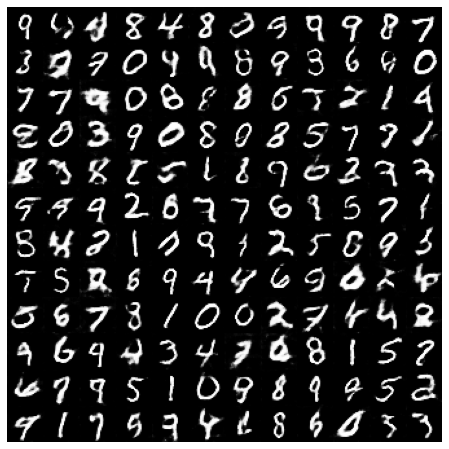

Epoch 10
[10][18750][0/1875] Loss_D: -0.2424 Loss_G: -0.8992
[10][18850][100/1875] Loss_D: -0.2040 Loss_G: -0.2804
[10][18950][200/1875] Loss_D: -0.2295 Loss_G: -0.3543
[10][19050][300/1875] Loss_D: -0.4352 Loss_G: 0.0496
[10][19150][400/1875] Loss_D: -0.2784 Loss_G: 0.3914
[10][19250][500/1875] Loss_D: -0.2868 Loss_G: 0.1026
[10][19350][600/1875] Loss_D: -0.2630 Loss_G: -0.0233
[10][19450][700/1875] Loss_D: -0.2313 Loss_G: -1.2549
[10][19550][800/1875] Loss_D: -0.3229 Loss_G: 0.0044
[10][19650][900/1875] Loss_D: -0.1066 Loss_G: -0.3747
[10][19750][1000/1875] Loss_D: -0.2528 Loss_G: -0.1625
[10][19850][1100/1875] Loss_D: -0.3581 Loss_G: -0.4592
[10][19950][1200/1875] Loss_D: -0.4014 Loss_G: -0.0802
[10][20050][1300/1875] Loss_D: -0.2505 Loss_G: 0.2225
[10][20150][1400/1875] Loss_D: -0.2785 Loss_G: 0.3602
[10][20250][1500/1875] Loss_D: -0.5165 Loss_G: -0.4803
[10][20350][1600/1875] Loss_D: -0.0876 Loss_G: -0.3233
[10][20450][1700/1875] Loss_D: -0.5509 Loss_G: 0.0443
[10][20550][1800/187

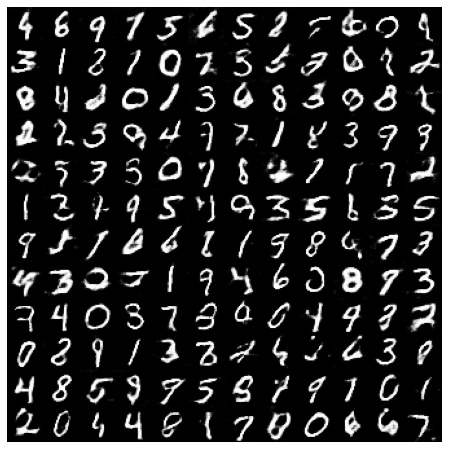

Epoch 11
[11][20625][0/1875] Loss_D: -0.2891 Loss_G: -0.1343
[11][20725][100/1875] Loss_D: -0.2948 Loss_G: 0.3698
[11][20825][200/1875] Loss_D: -0.4824 Loss_G: -0.2839
[11][20925][300/1875] Loss_D: -0.1556 Loss_G: -0.8576
[11][21025][400/1875] Loss_D: -0.3403 Loss_G: -0.0242
[11][21125][500/1875] Loss_D: -0.0436 Loss_G: 0.1189
[11][21225][600/1875] Loss_D: -0.2708 Loss_G: -0.3925
[11][21325][700/1875] Loss_D: -0.1471 Loss_G: -0.6548
[11][21425][800/1875] Loss_D: -0.2829 Loss_G: -0.2233
[11][21525][900/1875] Loss_D: -0.0812 Loss_G: 0.2436
[11][21625][1000/1875] Loss_D: -0.2434 Loss_G: -1.2967
[11][21725][1100/1875] Loss_D: -0.3982 Loss_G: -0.4584
[11][21825][1200/1875] Loss_D: -0.4192 Loss_G: 0.2041
[11][21925][1300/1875] Loss_D: -0.5049 Loss_G: 0.4391
[11][22025][1400/1875] Loss_D: -0.3112 Loss_G: 0.4021
[11][22125][1500/1875] Loss_D: -0.2100 Loss_G: -0.2857
[11][22225][1600/1875] Loss_D: -0.4950 Loss_G: -0.3679
[11][22325][1700/1875] Loss_D: -0.3739 Loss_G: 0.4777
[11][22425][1800/187

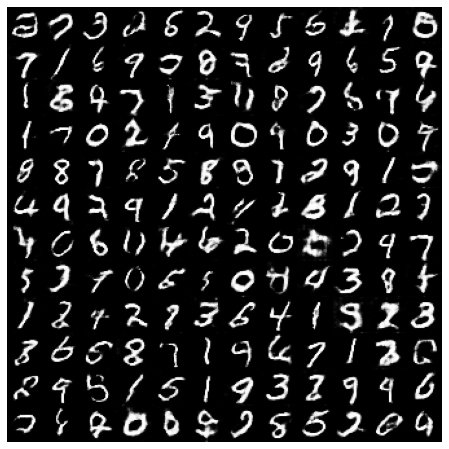

Epoch 12
[12][22500][0/1875] Loss_D: -0.2260 Loss_G: 0.1583
[12][22600][100/1875] Loss_D: -0.2581 Loss_G: -0.1365
[12][22700][200/1875] Loss_D: -0.3676 Loss_G: -0.7814
[12][22800][300/1875] Loss_D: -0.4521 Loss_G: 0.2743
[12][22900][400/1875] Loss_D: -0.1711 Loss_G: -0.4399
[12][23000][500/1875] Loss_D: -0.3798 Loss_G: -0.7901
[12][23100][600/1875] Loss_D: -0.3673 Loss_G: 0.5244
[12][23200][700/1875] Loss_D: -0.4093 Loss_G: -0.2190
[12][23300][800/1875] Loss_D: -0.3603 Loss_G: -0.3753
[12][23400][900/1875] Loss_D: -0.3115 Loss_G: 0.5676
[12][23500][1000/1875] Loss_D: -0.3155 Loss_G: -1.2043
[12][23600][1100/1875] Loss_D: -0.5227 Loss_G: -0.1814
[12][23700][1200/1875] Loss_D: -0.2293 Loss_G: -0.2774
[12][23800][1300/1875] Loss_D: -0.4196 Loss_G: -0.1504
[12][23900][1400/1875] Loss_D: -0.2603 Loss_G: 0.0586
[12][24000][1500/1875] Loss_D: -0.2576 Loss_G: -0.4006
[12][24100][1600/1875] Loss_D: -0.2992 Loss_G: 0.5101
[12][24200][1700/1875] Loss_D: -0.4199 Loss_G: -0.0208
[12][24300][1800/18

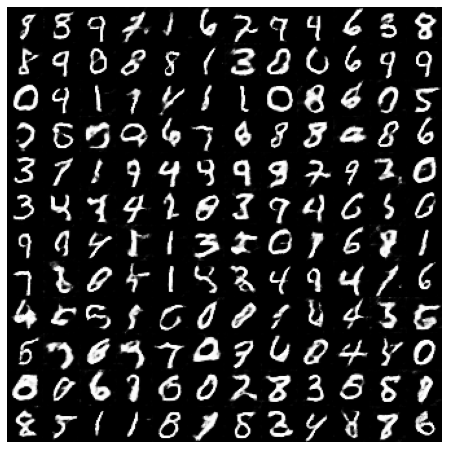

Epoch 13
[13][24375][0/1875] Loss_D: -0.2783 Loss_G: -0.1437
[13][24475][100/1875] Loss_D: -0.2602 Loss_G: -0.8980
[13][24575][200/1875] Loss_D: -0.2718 Loss_G: -0.4372
[13][24675][300/1875] Loss_D: -0.1815 Loss_G: -0.4202
[13][24775][400/1875] Loss_D: -0.4401 Loss_G: 0.5183
[13][24875][500/1875] Loss_D: -0.2844 Loss_G: 0.0810
[13][24975][600/1875] Loss_D: -0.2094 Loss_G: -0.6023
[13][25075][700/1875] Loss_D: -0.3636 Loss_G: 0.2767
[13][25175][800/1875] Loss_D: -0.2186 Loss_G: -0.6054
[13][25275][900/1875] Loss_D: -0.2960 Loss_G: -0.5670
[13][25375][1000/1875] Loss_D: -0.3109 Loss_G: -0.1007
[13][25475][1100/1875] Loss_D: -0.3667 Loss_G: 0.1525
[13][25575][1200/1875] Loss_D: -0.3011 Loss_G: -0.4006
[13][25675][1300/1875] Loss_D: -0.2404 Loss_G: -0.1373
[13][25775][1400/1875] Loss_D: -0.2306 Loss_G: -0.5454
[13][25875][1500/1875] Loss_D: -0.3591 Loss_G: -0.7726
[13][25975][1600/1875] Loss_D: -0.3416 Loss_G: -0.4156
[13][26075][1700/1875] Loss_D: -0.1998 Loss_G: 0.5714
[13][26175][1800/1

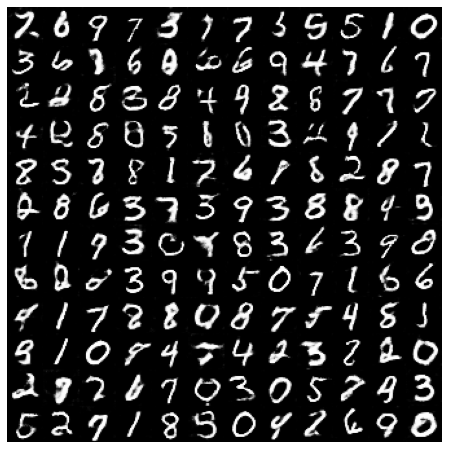

Epoch 14
[14][26250][0/1875] Loss_D: -0.3887 Loss_G: 0.2081
[14][26350][100/1875] Loss_D: -0.1635 Loss_G: -0.7702
[14][26450][200/1875] Loss_D: -0.3550 Loss_G: 0.4821
[14][26550][300/1875] Loss_D: -0.1990 Loss_G: -0.8291
[14][26650][400/1875] Loss_D: -0.3084 Loss_G: 0.0608
[14][26750][500/1875] Loss_D: -0.3384 Loss_G: -0.5543
[14][26850][600/1875] Loss_D: -0.2392 Loss_G: 0.0036
[14][26950][700/1875] Loss_D: -0.1185 Loss_G: 0.1129
[14][27050][800/1875] Loss_D: -0.3072 Loss_G: -0.5617
[14][27150][900/1875] Loss_D: -0.3003 Loss_G: -0.5249
[14][27250][1000/1875] Loss_D: -0.3273 Loss_G: 0.3876
[14][27350][1100/1875] Loss_D: -0.3525 Loss_G: -0.8624
[14][27450][1200/1875] Loss_D: -0.3454 Loss_G: 0.0974
[14][27550][1300/1875] Loss_D: -0.2253 Loss_G: 0.1681
[14][27650][1400/1875] Loss_D: -0.1600 Loss_G: -0.6597
[14][27750][1500/1875] Loss_D: -0.3583 Loss_G: 0.2250
[14][27850][1600/1875] Loss_D: -0.3419 Loss_G: -0.1152
[14][27950][1700/1875] Loss_D: -0.4534 Loss_G: -0.0196
[14][28050][1800/1875]

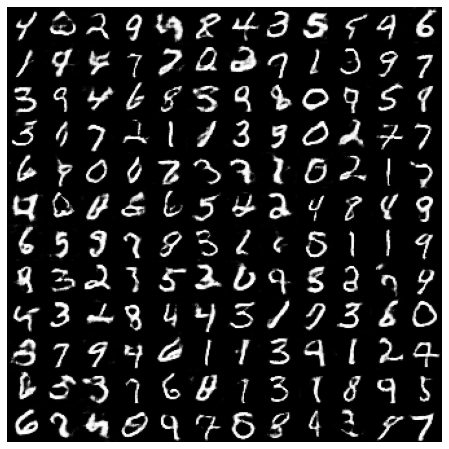

Epoch 15
[15][28125][0/1875] Loss_D: -0.1367 Loss_G: -0.0072
[15][28225][100/1875] Loss_D: -0.1521 Loss_G: -0.5469
[15][28325][200/1875] Loss_D: -0.3800 Loss_G: 0.0408
[15][28425][300/1875] Loss_D: -0.2262 Loss_G: -0.1760
[15][28525][400/1875] Loss_D: -0.0823 Loss_G: -0.6239
[15][28625][500/1875] Loss_D: -0.3543 Loss_G: 0.1676
[15][28725][600/1875] Loss_D: -0.1818 Loss_G: -0.3493
[15][28825][700/1875] Loss_D: -0.3961 Loss_G: -0.1315
[15][28925][800/1875] Loss_D: -0.3890 Loss_G: 0.0058
[15][29025][900/1875] Loss_D: -0.2809 Loss_G: -0.6794
[15][29125][1000/1875] Loss_D: -0.2999 Loss_G: -0.4788
[15][29225][1100/1875] Loss_D: -0.2144 Loss_G: -0.4487
[15][29325][1200/1875] Loss_D: -0.1696 Loss_G: -0.2071
[15][29425][1300/1875] Loss_D: -0.3282 Loss_G: -0.7289
[15][29525][1400/1875] Loss_D: -0.4742 Loss_G: -0.5286
[15][29625][1500/1875] Loss_D: -0.2643 Loss_G: 0.0320
[15][29725][1600/1875] Loss_D: -0.2737 Loss_G: -1.3538
[15][29825][1700/1875] Loss_D: -0.0457 Loss_G: 0.2166
[15][29925][1800/1

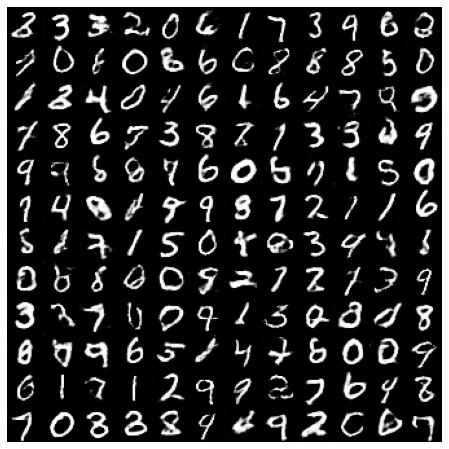

Epoch 16
[16][30000][0/1875] Loss_D: -0.0607 Loss_G: 0.3953
[16][30100][100/1875] Loss_D: -0.2516 Loss_G: -1.0953
[16][30200][200/1875] Loss_D: -0.2041 Loss_G: -0.1617
[16][30300][300/1875] Loss_D: -0.2140 Loss_G: -0.1112
[16][30400][400/1875] Loss_D: -0.2177 Loss_G: -0.0458
[16][30500][500/1875] Loss_D: -0.2768 Loss_G: 0.1033
[16][30600][600/1875] Loss_D: -0.2758 Loss_G: -1.3049
[16][30700][700/1875] Loss_D: -0.1177 Loss_G: 0.5189
[16][30800][800/1875] Loss_D: -0.3264 Loss_G: -0.8264
[16][30900][900/1875] Loss_D: -0.3971 Loss_G: 0.0798
[16][31000][1000/1875] Loss_D: -0.2589 Loss_G: -0.6111
[16][31100][1100/1875] Loss_D: -0.2910 Loss_G: -0.0103
[16][31200][1200/1875] Loss_D: -0.3918 Loss_G: -0.4235
[16][31300][1300/1875] Loss_D: -0.3442 Loss_G: 0.1895
[16][31400][1400/1875] Loss_D: -0.2245 Loss_G: -0.5233
[16][31500][1500/1875] Loss_D: -0.4441 Loss_G: 0.0975
[16][31600][1600/1875] Loss_D: -0.2180 Loss_G: 0.0555
[16][31700][1700/1875] Loss_D: -0.1194 Loss_G: -0.7504
[16][31800][1800/187

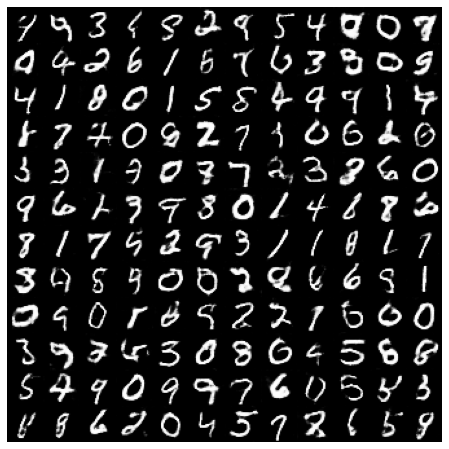

Epoch 17
[17][31875][0/1875] Loss_D: -0.3332 Loss_G: -0.5252
[17][31975][100/1875] Loss_D: -0.0076 Loss_G: -0.0694
[17][32075][200/1875] Loss_D: -0.3398 Loss_G: -0.6231
[17][32175][300/1875] Loss_D: -0.1717 Loss_G: 0.0190
[17][32275][400/1875] Loss_D: -0.2703 Loss_G: -0.4584
[17][32375][500/1875] Loss_D: -0.4599 Loss_G: -0.4871
[17][32475][600/1875] Loss_D: -0.2521 Loss_G: -0.2495
[17][32575][700/1875] Loss_D: -0.3644 Loss_G: 0.4785
[17][32675][800/1875] Loss_D: -0.1547 Loss_G: -0.9255
[17][32775][900/1875] Loss_D: -0.3517 Loss_G: 0.4066
[17][32875][1000/1875] Loss_D: -0.3469 Loss_G: -0.9045
[17][32975][1100/1875] Loss_D: -0.3314 Loss_G: 0.1604
[17][33075][1200/1875] Loss_D: -0.1165 Loss_G: -0.1557
[17][33175][1300/1875] Loss_D: -0.1574 Loss_G: -0.1605
[17][33275][1400/1875] Loss_D: -0.0578 Loss_G: -0.5434
[17][33375][1500/1875] Loss_D: -0.2195 Loss_G: -0.7456
[17][33475][1600/1875] Loss_D: -0.2307 Loss_G: 0.3856
[17][33575][1700/1875] Loss_D: -0.3007 Loss_G: -0.6818
[17][33675][1800/1

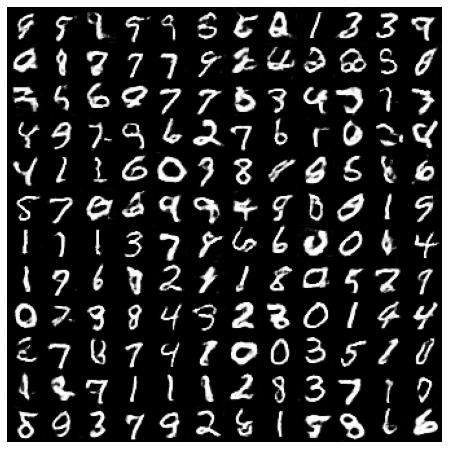

Epoch 18
[18][33750][0/1875] Loss_D: -0.1452 Loss_G: -1.1091
[18][33850][100/1875] Loss_D: -0.1814 Loss_G: 0.1735
[18][33950][200/1875] Loss_D: -0.2761 Loss_G: -0.8842
[18][34050][300/1875] Loss_D: -0.4355 Loss_G: 0.2060
[18][34150][400/1875] Loss_D: -0.2578 Loss_G: -1.0005
[18][34250][500/1875] Loss_D: -0.1317 Loss_G: 0.4112
[18][34350][600/1875] Loss_D: -0.2826 Loss_G: -0.6495
[18][34450][700/1875] Loss_D: -0.2925 Loss_G: 0.0012
[18][34550][800/1875] Loss_D: -0.1833 Loss_G: -0.1652
[18][34650][900/1875] Loss_D: -0.2979 Loss_G: -0.9617
[18][34750][1000/1875] Loss_D: -0.2896 Loss_G: 0.5918
[18][34850][1100/1875] Loss_D: -0.1209 Loss_G: -0.7428
[18][34950][1200/1875] Loss_D: -0.2702 Loss_G: -0.3766
[18][35050][1300/1875] Loss_D: -0.1942 Loss_G: 0.0344
[18][35150][1400/1875] Loss_D: -0.2260 Loss_G: -0.3033
[18][35250][1500/1875] Loss_D: -0.1952 Loss_G: -0.2275
[18][35350][1600/1875] Loss_D: -0.1646 Loss_G: -0.5601
[18][35450][1700/1875] Loss_D: -0.1889 Loss_G: -0.2785
[18][35550][1800/18

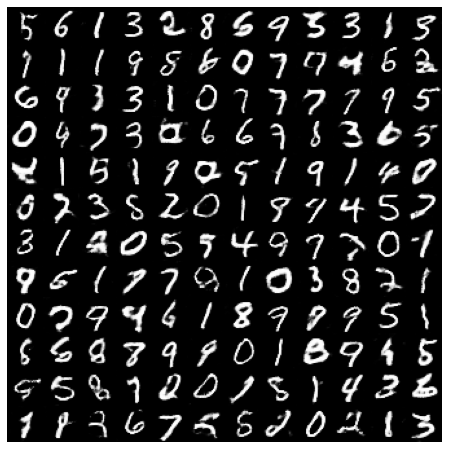

Epoch 19
[19][35625][0/1875] Loss_D: -0.1831 Loss_G: 0.4014
[19][35725][100/1875] Loss_D: -0.0671 Loss_G: -0.9744
[19][35825][200/1875] Loss_D: -0.2919 Loss_G: 0.0311
[19][35925][300/1875] Loss_D: -0.3069 Loss_G: -0.3035
[19][36025][400/1875] Loss_D: -0.3390 Loss_G: -0.4662
[19][36125][500/1875] Loss_D: -0.2447 Loss_G: 0.1046
[19][36225][600/1875] Loss_D: -0.1239 Loss_G: -1.4197
[19][36325][700/1875] Loss_D: -0.2346 Loss_G: 0.1141
[19][36425][800/1875] Loss_D: -0.1596 Loss_G: -0.5175
[19][36525][900/1875] Loss_D: -0.3593 Loss_G: 0.3467
[19][36625][1000/1875] Loss_D: -0.2292 Loss_G: -0.3874
[19][36725][1100/1875] Loss_D: -0.1549 Loss_G: -0.3443
[19][36825][1200/1875] Loss_D: -0.2029 Loss_G: 0.2414
[19][36925][1300/1875] Loss_D: -0.2757 Loss_G: -0.3162
[19][37025][1400/1875] Loss_D: -0.1735 Loss_G: 0.0232
[19][37125][1500/1875] Loss_D: -0.0480 Loss_G: -0.3665
[19][37225][1600/1875] Loss_D: -0.2750 Loss_G: 0.6402
[19][37325][1700/1875] Loss_D: -0.1774 Loss_G: -0.6226
[19][37425][1800/1875

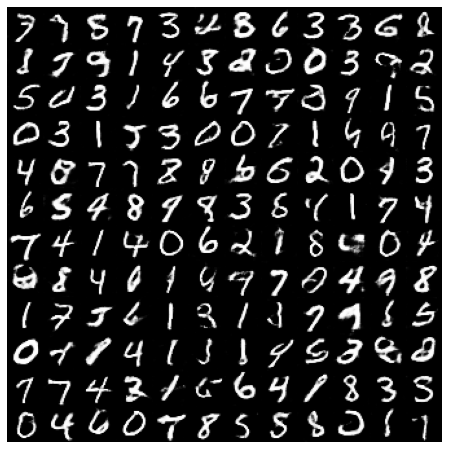

In [21]:
if not skip_training:
    # YOUR CODE HERE
    n_epochs = 20
    iters = 0
    lmbda = 10
    n_critic = 5  # number of critic iterations per generation iteration
    g_loss_cum, critic_loss_cum, cum_score = [], [], []
    optim_g = torch.optim.Adam(netG.parameters(), lr=0.0001)
    optim_critic = torch.optim.Adam(netD.parameters(), lr=0.0001)

    for e in range(n_epochs):
        print(f"Epoch {e}")
        for i, batch in enumerate(trainloader):
            real_images, _ = map(lambda x: x.to(device), batch)
            batch_size = real_images.size(0)
            ####################################################################
            # Train the critic
            ####################################################################
            # for _ in range(n_critic):
            optim_critic.zero_grad()

            # Sample noise
            z = torch.randn((batch_size, nz, 1, 1), device=device)
            fake_images = netG(z)#.detach()

            # Compute the critic loss
            d_loss = critic_loss(netD, real_images, fake_images)
            grad_penalty, _ = gradient_penalty(netD, real_images, fake_images.detach())
            critic_loss_total = d_loss + lmbda*grad_penalty
            critic_loss_cum.append(critic_loss_total.item())

            critic_loss_total.backward()
            optim_critic.step()

            ####################################################################
            # Train the generator
            ####################################################################
            if i % n_critic == 0:
                optim_g.zero_grad()

                z = torch.randn((batch_size, nz, 1, 1), device=device)
                fake_images = netG(z)#.detach()

                # Compute the generator loss
                g_loss = generator_loss(netD, fake_images) #.detach()
                g_loss_cum.append(g_loss.item())

                g_loss.backward()
                optim_g.step()
            
            if i % 100 == 0:
                print('[%d][%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                % (e, iters, i, len(trainloader),
                    critic_loss_total.item(), g_loss.item()))
            iters += 1

        with torch.no_grad():
            # Plot generated images
            z = torch.randn(144, nz, 1, 1, device=device)
            samples = netG(z)
            tools.plot_generated_samples(samples)
            
            # Compute score
            z = torch.randn(1000, nz, 1, 1, device=device)
            samples = netG(z)
            samples = (samples + 1) / 2  # Re-normalize to [0, 1]
            score = scorer(samples)
            cum_score.append(score)

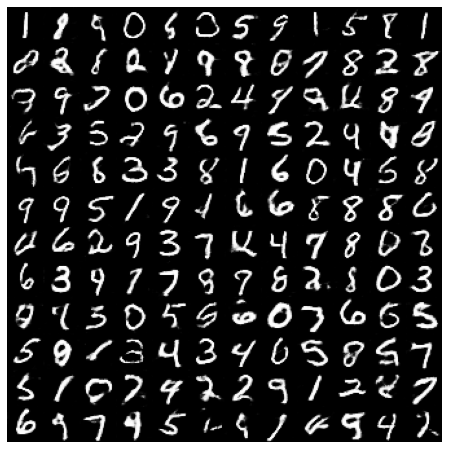

In [22]:
with torch.no_grad():
    # Plot generated images
    z = torch.randn(144, nz, 1, 1, device=device)
    samples = netG(z)
    tools.plot_generated_samples(samples)
    
    # Compute score
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = netG(z)
    samples = (samples + 1) / 2  # Re-normalize to [0, 1]
    score = scorer(samples)
    cum_score.append(score)

In [23]:
score

tensor(0.7021, device='cuda:0')

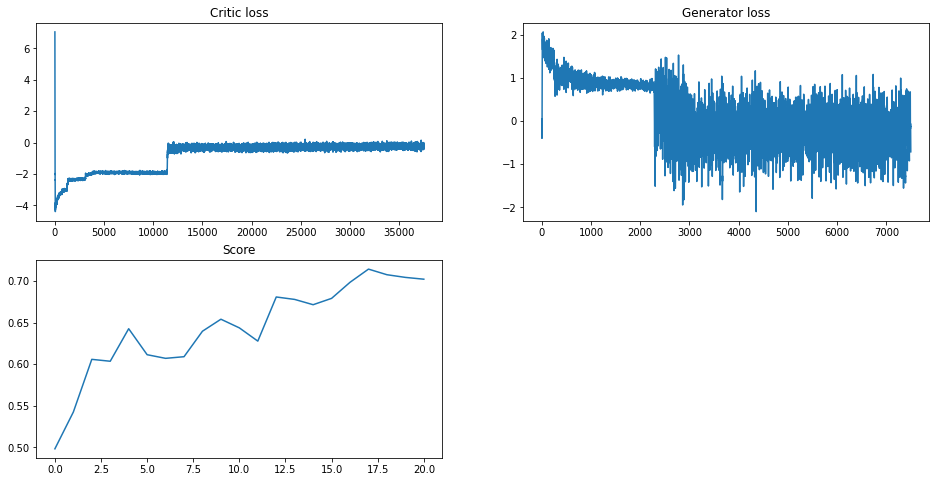

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))
ax1.plot(critic_loss_cum, label='Critic')
ax1.set_title("Critic loss")
ax2.plot(g_loss_cum, label='Generator')
ax2.set_title("Generator loss")
ax3.plot(cum_score, label='Score')
ax3.set_title("Score")
ax4.remove()
# plt.legend()

In [25]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    tools.save_model(netG, '11_wgan_g.pth')
    tools.save_model(netD, '11_wgan_d.pth')
else:
    nz = 10
    netG = Generator(nz=nz, ngf=128, nc=1)
    netD = Critic(nc=1, ndf=128)
    
    tools.load_model(netG, '11_wgan_g.pth', device)
    tools.load_model(netD, '11_wgan_d.pth', device)

Do you want to save the model (type yes to confirm)? yes
Model saved to 11_wgan_g.pth.
Do you want to save the model (type yes to confirm)? yes
Model saved to 11_wgan_d.pth.


In [26]:
# Evaluate generated samples
with torch.no_grad():
    z = torch.randn(2000, nz, 1, 1, device=device)
    samples = (netG(z) + 1) / 2
    score = scorer(samples)

print(f'The trained WGAN-GP achieves a score of {score:.5f}')
assert score >= 0.66, "Poor GAN score! Check your architecture and training."
print('Success')

The trained WGAN-GP achieves a score of 0.71114
Success
